In [12]:
import pandas as pd
import numpy as np
 
# Enlève les notations scientifiques des arrays
np.set_printoptions(suppress=True)
 

 
############################################
# Stock price history grâce à nsepy
'''Il est conseillée d'indiquer une date de début au minimum pour éviter
un temps de calcul et une allocation des ressources trop importante'''


from nsepy import get_history #obtient stocks
from datetime import datetime #permet de parcourir les lignes de stocks/à leur date


startDate=datetime(2019, 1,1) 
endDate=datetime(2020, 10, 5)
 
# Fetching the data
'''On parcourt ici lhistoire des prix des actions de lentreprise INFY'''
StockData=get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)

(436, 14)


## Visualiser les données ci dessus

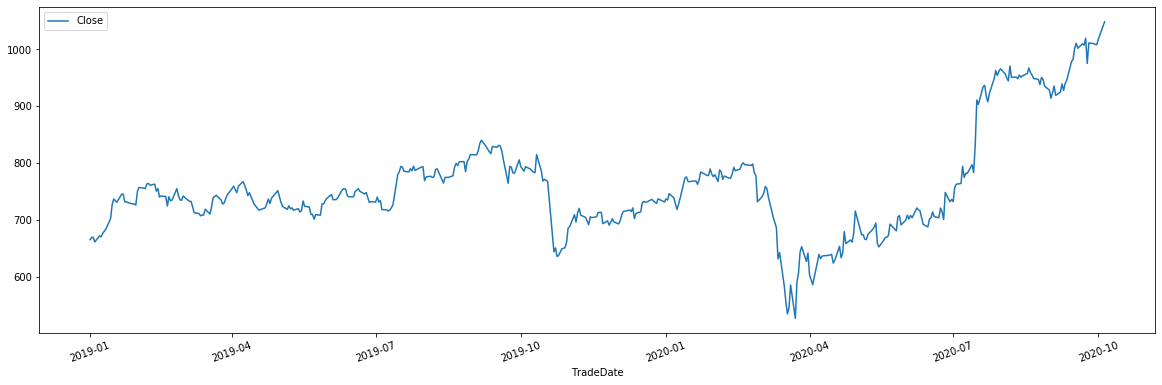

In [13]:
# Date comme colonne ->role d'abcisse
StockData['TradeDate']=StockData.index
 
# Affichage des stocks price
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

## Preparing the data

On doit mettre en input des variables X et Y pour que le modele marche. 
X représenter les 10 derniers prix et y le 11eme

L'idée est que le modele apprenne le mouvement de prix des 2 dernières années. Il devrait ainsi pouvoir prédire le prix au 11eme jour grâce aux 10 derniers

La première étape est ici de normaliser/standardiser les données pour ensuite pouvoir les utiliser

In [14]:
# Extraction des closing prices-------------------------------------
FullData=StockData[['Close']].values
print(FullData[0:5]) #vérification de FullData
 
# Feature Scaling : entrainement du réseau neuronal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Normalisation-------------------------------------
sc=MinMaxScaler() #Transforme paramètres en les normalisant séparément à une taille donnée
 
DataScaler = sc.fit(FullData) #Compute le minimum et maximum servant ci dessous.
X=DataScaler.transform(FullData) #Normalise les paramètres de FullData 
 
print('After Normalization \n', X[0:5])


[[665.05]
 [669.05]
 [669.15]
 [661.05]
 [671.7 ]]
After Normalization 
 [[0.26539014]
 [0.27304931]
 [0.27324079]
 [0.25773097]
 [0.2781235 ]]


## Preparation des données au LSTM

In [15]:
# Listes de test pour vérification des exemples
X_samples = []
y_samples = []

NumerOfRows = len(X)
TimeSteps=10  # dernier jour d'apprentissage
 
# Création de combinaison pour apprentissage renforcé
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 

# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
y_data=np.array(y_samples) #y rese une matrice de 1 colonne
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(426, 10, 1)

#### Output Data shape ####
(426, 1)


## Training & Test

In [16]:
# Nb d'archives testées
TestingRecords=5
 
# Séparation en train et test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 

 
# Vérification des domensions
print('\n Training Data shape')
print(X_train.shape)
print(y_train.shape)
print('\n Testing Data shape ')
print(X_test.shape)
print(y_test.shape)


 Training Data shape
(421, 10, 1)
(421, 1)

 Testing Data shape 
(5, 10, 1)
(5, 1)


## Creating the Deep learning lstm model

Pour plus de précision voir partie théorique d'un modèle lstm

In [17]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


Concerant la bibliothèque keras : 

Keras est une bibliothèque de réseaux neuronaux de haut niveau, développée dans le but de permettre une expérimentation rapide. 

-Permet un prototypage simple et rapide (grâce à une modularité totale, un minimalisme et une extensibilité).

-Prend en charge à la fois les réseaux convolutifs et les réseaux récurrents, ainsi que les combinaisons des deux.

-Prend en charge les schémas de connectivité arbitraires (y compris la formation multi-entrées et multi-sorties).

In [18]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# RNN
regressor = Sequential()
 
# 1ère couche du RNN + LSTM
#Voir documentation https://faroit.com/keras-docs/1.1.1/ pour le fonctionnement de keras
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# 2eme couche du RNN + LSTM
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# 3eme couche du RNN + LSTM
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
#Output de sortie
regressor.add(Dense(units = 1))
 
# Compilation
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Temps nécessaire à l'entrainement
StartTime=time.time()
 
# Fit le RNN aux données de training
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("Temps d'attente total: ", round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/100
85/85 [==============================] - 6s 11ms/step - loss: 0.1765
Epoch 2/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0217
Epoch 3/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0113
Epoch 4/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0065
Epoch 5/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 6/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0061
Epoch 7/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0039
Epoch 8/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0054
Epoch 9/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 10/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 11/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 12/100
85/85 [==============================] - 1s 11ms/step - loss: 0.0041
Epoch 13/100
85/85 [=====

## Measuring the accuracy of the model on testing data

Accuracy: 97.72102970240378


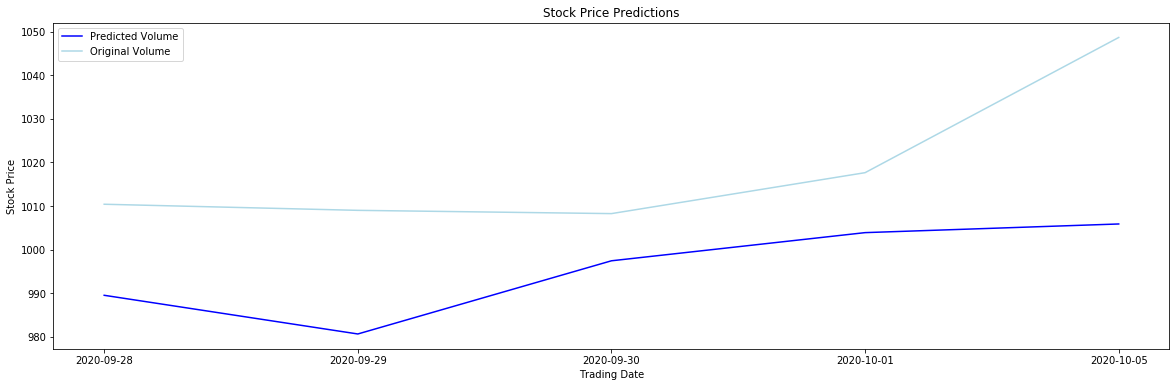

In [10]:
'''Vérification que les prix des 5 derniers jours concordent avec les 
prix actuels'''

# Predictions sur données de test
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Prix original des données de test
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Précision de la prédiction
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Affichage des résultats
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Visualizing the predictions for full data

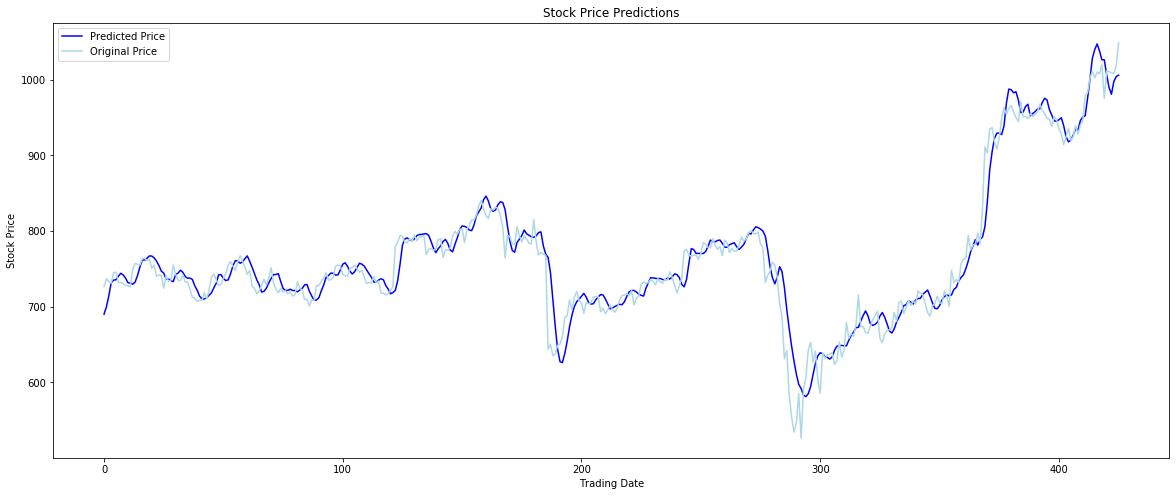

In [11]:
# Prédictions sur l'ensemble des données
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# Affichage des données
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## Predict the stock price for tomorrow

In [12]:
# Prix des 10 derniers jours
Last10Days=np.array([1002.15, 1009.9, 1007.5, 1019.75, 975.4,
            1011.45, 1010.4, 1009,1008.25, 1017.65])
 
# Normalisation
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 

NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
 
#Prédictions
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[1005.8696]], dtype=float32)

# Prediction du prix des 5 prochains jours

## Preparation de données pour Multi Step LSTM


In [13]:

print('Original Prices')
print(FullData[-10:])
 
print('###################')
 
# Affichage des 10 dernièrs prix normalisés 
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[1009.9 ]
 [1007.5 ]
 [1019.75]
 [ 975.4 ]
 [1011.45]
 [1010.4 ]
 [1009.  ]
 [1008.25]
 [1017.65]
 [1048.7 ]]
###################
Scaled Prices
[0.92570608 0.92111058 0.94456678 0.85964576 0.92867401 0.92666348
 0.92398277 0.92254667 0.94054572 1.        ]


In [14]:
# Multi step data preparation
 
# Séparation en listes
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10 #apprentissage depuis 10 derniers jours
FutureTimeSteps=5 # 5 prochains jours
 
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
 
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(421, 10, 1)
### Output Data Shape ###
(421, 5)


## Splitting the data into Training and Testing


In [15]:
TestingRecords=5
 
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(416, 10, 1)
(416, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


## Creation du modèle Deep Learning Multi-Step LSTM


In [16]:
# RNN
regressor = Sequential()
 
# Couche cachée 1 + lstm
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Couche cachée 2 + lstm
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
#Couche de sortie
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
StartTime=time.time()
 
# Fit le RNN aux données de training
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
84/84 [==============================] - 3s 8ms/step - loss: 0.2181
Epoch 2/100
84/84 [==============================] - 1s 6ms/step - loss: 0.1407
Epoch 3/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0843
Epoch 4/100
84/84 [==============================] - 1s 6ms/step - loss: 0.0499
Epoch 5/100
84/84 [==============================] - 1s 6ms/step - loss: 0.0319
Epoch 6/100
84/84 [==============================] - 1s 7ms/step - loss: 0.0215
Epoch 7/100
84/84 [==============================] - 1s 7ms/step - loss: 0.0159A: 0s - loss
Epoch 8/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0145
Epoch 9/100
84/84 [==============================] - 1s 6ms/step - loss: 0.0133
Epoch 10/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0117
Epoch 11/100
84/84 [==============================] - 1s 7ms/step - loss: 0.0124
Epoch 12/100
84/84 [==============================] - 1s 7ms/step - loss: 0.0103
Epoch 13/100
84/84 [=====

## Précision du modèle sur données de test


In [17]:
#Predictions sur données de test
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
#Comparaison aux prix originaux des variables de test
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

#### Predicted Prices ####
[[1019.2617  1022.65955 1017.93475 1020.04987 1027.9143 ]
 [1030.118   1033.6033  1028.6946  1030.8153  1038.8984 ]
 [1029.2815  1032.9318  1028.3873  1030.4008  1037.937  ]
 [1041.0571  1044.539   1039.2584  1041.4418  1050.0278 ]
 [ 988.45654  993.0815   991.8843   993.0657   995.75903]]

#### Original Prices ####
[[1009.9  1007.5  1019.75  975.4  1011.45]
 [1007.5  1019.75  975.4  1011.45 1010.4 ]
 [1019.75  975.4  1011.45 1010.4  1009.  ]
 [ 975.4  1011.45 1010.4  1009.   1008.25]
 [1011.45 1010.4  1009.   1008.25 1017.65]]


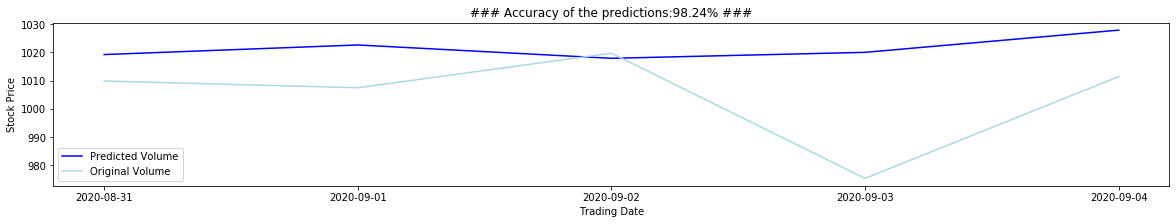

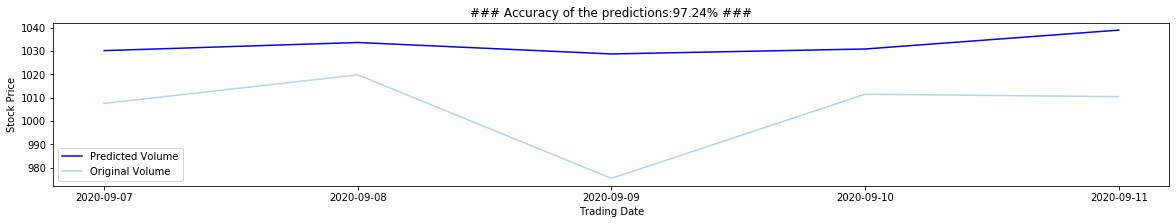

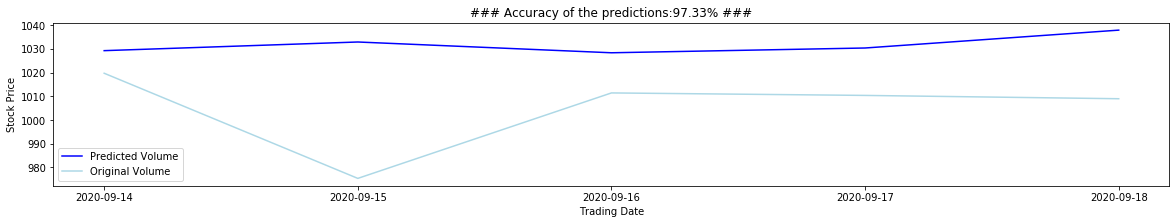

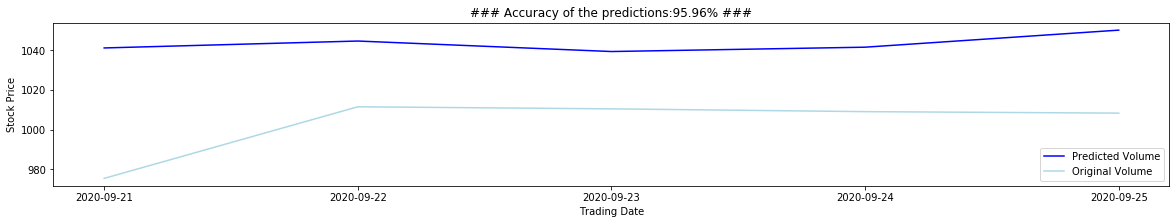

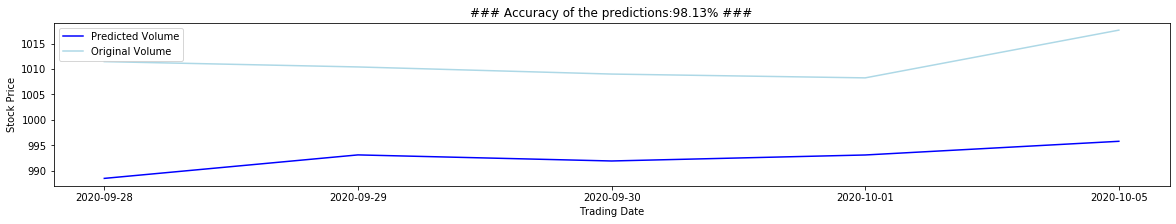

In [18]:
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]
 
    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['TradeDate'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

## Prediction for the next 5 days

In [20]:
Last10DaysPrices=np.array([1376.2, 1371.75,1387.15,1370.5 ,1344.95, 
                   1312.05, 1316.65, 1339.45, 1339.7 ,1340.85])
 
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]

X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
Next5DaysPrice = regressor.predict(X_test)
 
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

array([[1281.5884, 1285.9541, 1274.4557, 1277.4185, 1294.0963]],
      dtype=float32)